# Generate samples for a single scene

In [5]:
import sys
import os
import pylab as plt
import numpy as np
from matplotlib.colors import ListedColormap
from osgeo import gdal
from osgeo import ogr
from importlib import reload
from shapely.geometry import Polygon
from shapely.wkb import loads
import skimage

sys.path.insert(0, '../src')
import deepleeo.dataset.data_augment as dtaug
import deepleeo.dataset.rasterizer as rstzr
import deepleeo.dataset.preprocessor as prep
import deepleeo.dataset.chipsGenerator as cg
import deepleeo.utils.filesystem as fs
import deepleeo.utils.geofunctions as gf
from deepleeo.utils import image

reload(dtaug)
reload(rstzr)
reload(prep)
reload(cg)
reload(fs)

%matplotlib inline

In [6]:
# Input Files
DATA_DIR = os.path.join(os.path.abspath(os.path.dirname("__file__")), '../', 'data_real')
shape_file = os.path.join(DATA_DIR, 'PRODES2016_225-64_REP.shp')
raster_file = os.path.join(DATA_DIR, "Landsat8_225064_17072016_R6G5B4_clip.tif")
#class_column = "agregClass"
class_column = "bin_class"

# Output Files
output_path = os.path.join(DATA_DIR, 'generated')
fs.mkdir(output_path)
output_shp = os.path.join(output_path, "samples.shp")
output_npz = os.path.join(output_path, "samples_dataset_bin.npz")

number_of_samples = 5000
window_size = 128

## Rasterize the input shape file

In [7]:
rasterizer = rstzr.Rasterizer(shape_file, raster_file, class_column)
rasterizer.collect_class_names()
rasterizer.rasterize_layer()
class_names = rasterizer.get_class_names()
rasterized_layer = rasterizer.get_labeled_raster()

Raster Shape: (6166, 6711, 1)
UNIQUE:  [0 1 --]


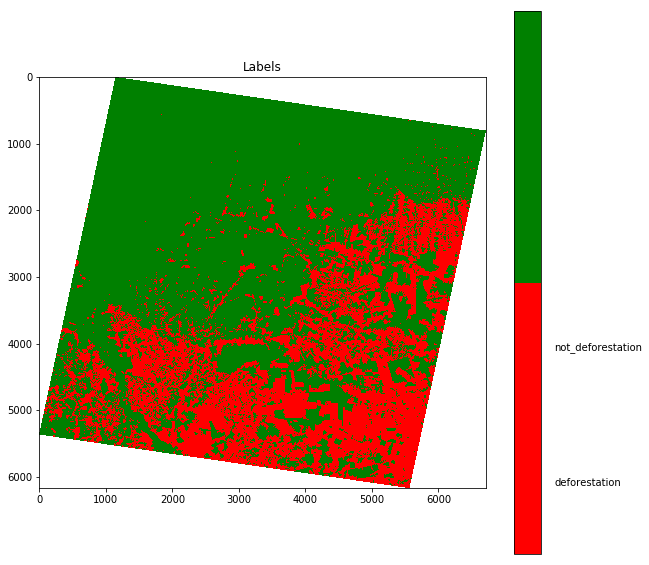

In [11]:
plt.figure(figsize=(10, 10))
plt.title('Labels')
print("Raster Shape:", rasterized_layer.shape)
labels = np.ma.masked_where(rasterized_layer == 255, rasterized_layer) # TODO: Is this line necessary? Try to comment it

#colorMap = ListedColormap(["red", "green", "blue", "yellow"])
colorMap = ListedColormap(["red", "green"])
plt.imshow(rasterized_layer[:,:,0], cmap=colorMap)
cbar = plt.colorbar()
cbar.ax.get_yaxis().set_ticks([])

for j, lab in enumerate(class_names):
    cbar.ax.text(1.5, (2 * j + 1) / 8, lab, ha='left')

cbar.ax.get_yaxis().labelpad = 15
print("UNIQUE: ", np.unique(labels))

SHAPE:  (6166, 6711, 3)


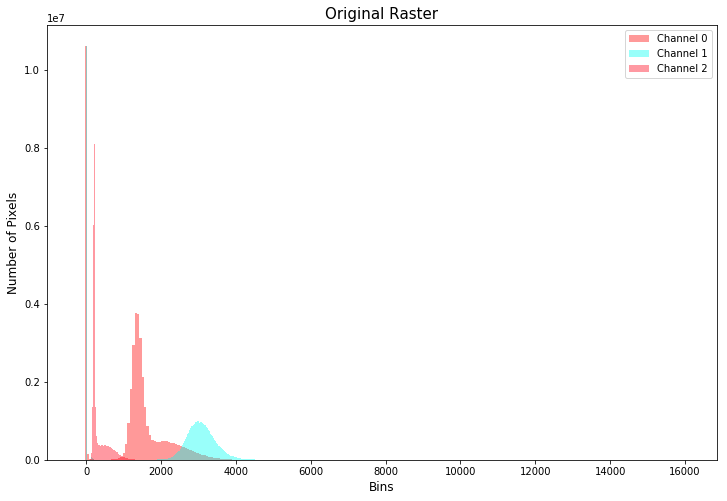

/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/skimage/util/dtype.py:118: UserWarning: Possible sign loss when converting negative image of type int16 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from int16 to uint8
  .format(dtypeobj_in, dtypeobj_out))


(-0.5, 6710.5, 6165.5, -0.5)

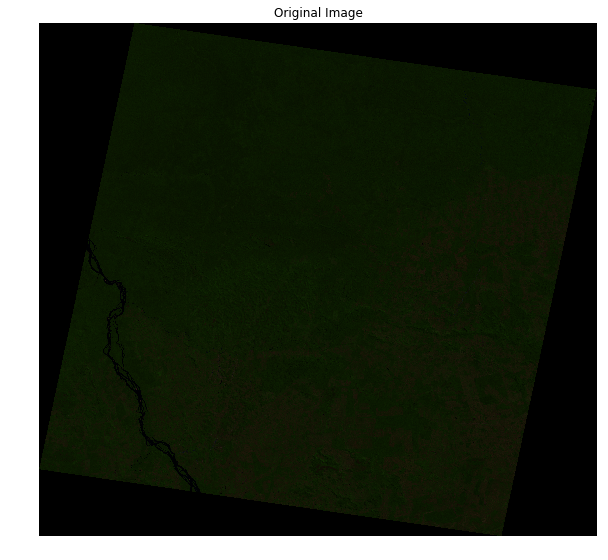

In [12]:
preproc = prep.Preprocessor(raster_file, no_data=-9999)
original_raster = preproc.get_raster_stacked_raster()
print("SHAPE: ", original_raster.shape)
image.plot_image_histogram(original_raster, title="Original Raster")

original_raster = skimage.img_as_ubyte(original_raster)
plt.figure(figsize=(10, 10))
plt.title('Original Image')
plt.imshow(original_raster)
plt.axis('off')

[0.         0.00546952 0.00651426 ... 0.85269177 0.8915929  1.        ]


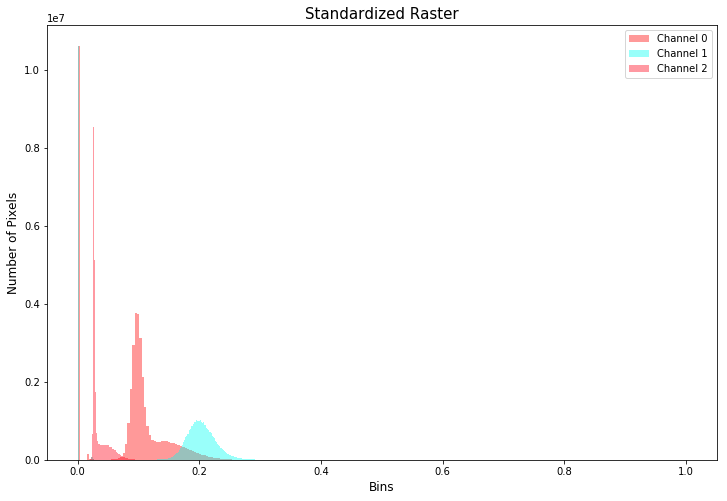

In [13]:
preproc.standardize_image("norm_0-1")
raster_img = preproc.get_raster_stacked_raster()
print(np.unique(raster_img))
image.plot_image_histogram(raster_img, title="Standardized Raster")

In [14]:
#raster_ds = gdal.Open(raster_file)
#raster_img = raster_ds.ReadAsArray()
#raster_img = np.rollaxis(raster_img, 0, start=3)
reload(cg)
chpGen = cg.ChipsGenerator(raster_img, rasterized_layer, class_names, raster_file)
chpGen.compute_sample_indexes(number_of_samples)
chpGen.extract_windows(window_size)
chpGen.save_samples_SHP(output_shp)
chpGen.save_samples_NPZ(output_npz)

UNIQUE:  [0 1]


In [38]:
# - Create execute method. 
# - Implement method to save to geotiff. In this method, allow the user to pass a list of indexes to save (none saves everything)

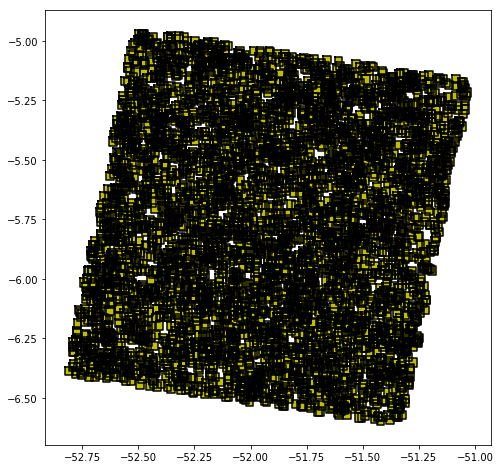

In [39]:
#TODO: How to plot the raster together? Decrease the blank space from the origin to the data
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
out_ds = ogr.Open(output_shp)

layer = out_ds.GetLayerByName(os.path.splitext(os.path.basename(output_shp))[0])
parcel = layer.GetNextFeature()

while parcel is not None:
    polygon = loads(parcel.GetGeometryRef().ExportToWkb())
    xCoord , yCoord = polygon.exterior.xy
    ax.fill(xCoord,yCoord,"y")
    ax.plot(xCoord,yCoord, "k-")
    parcel = layer.GetNextFeature()

out_ds.Destroy()

In [ ]:
#TODO: Sometimes this error is occurring. Verify it.
# https://stackoverflow.com/questions/46902367/numpy-array-typeerror-only-integer-scalar-arrays-can-be-converted-to-a-scalar-i 
samples = chpGen.getSamples()
plt.figure(figsize=(15,15))

#TODO: Some samples has no data value only in labels. Is it necessary to remove no data or clip the base raster?
# Why is the forest being printed in yellow?? Search for how to set colors by values. It seems to be by range
colorList = ["red", "green", "blue", "yellow"]
count = 1
for x in range(1, 13):
    pos = np.random.randint(len(samples["images"]))
    smpImg = samples["images"][pos]
    smpImg = skimage.img_as_float(smpImg).astype(np.float32)
    plt.subplot(5, 5, count)
    plt.title("%s %d" % ("sample ", pos))
    plt.axis('off')
    plt.imshow(smpImg[:,:,[5,4,3]], interpolation='nearest')
    count=count+1
    
    lblImg = samples["labels"][pos]
    plt.subplot(5, 5, count)
    plt.title("%s %d" % ("label ", pos))
    plt.axis('off')
    # Mounting the color map for this sample
    palette = []
    for val in np.unique(lblImg):
        if not val == 255:
            #print("VAL: ", val)
            #print("ColorList[val]: ", colorList[val])
            palette.append(colorList[val])
    colorMap = ListedColormap(palette)
    plt.imshow(lblImg[:,:,0], interpolation='nearest', cmap=colorMap)
    count=count+1